# Single-View Geometry (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the *Single-View Geometry* section of Assignment 3. In [main function](#Main-function), we outline the required functionalities step by step. Some of the functions which involves interactive plots are already provided, but [the rest](#Your-implementation) are left for you to implement.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- In this code, we use `tkinter` package. Installation instruction can be found [here](https://anaconda.org/anaconda/tk).

In [18]:
import sys  
!{sys.executable} -m pip install opencv-python


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\Genghis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Common imports

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from PIL import Image
import pickle

In [20]:
% matplotlib tk

UsageError: Line magic function `%` not found.


# Provided functions

In [21]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.axis('off')
    plt.imshow(im)
    print(f'Set at least {min_lines} lines to compute vanishing point')
    print(f'The delete and backspace keys act like right clicking')
    print(f'The enter key acts like middle clicking')
    while True:
        print('Click the two endpoints, use the right button (delete and backspace keys) to undo, and use the middle button to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print(f'Need at least {min_lines} lines, you have {n} now')
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [22]:
def plot_lines_and_vp(ax, im, lines, vp):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10
    
    ax.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    ax.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    ax.set_xlim([bx1, bx2])
    ax.set_ylim([by2, by1])

# Your implementation

In [23]:
def get_vanishing_point(lines):
    """
    Solves for the vanishing point using the user-input lines.
    """
    # input: n, number of points
    A = lines.T
    u, s, vh = np.linalg.svd(A)
    p = vh[-1]
    return p

In [24]:
def get_horizon_line(pz, px):
    """
    Calculates the ground horizon line.
    """
    # input: pz, px, two vanishing points in the horizontal direction
    # output: line expression
    line = np.cross(pz, px)
    normalize_factor = np.sqrt(line[0]**2 + line[1]**2)
    return line / normalize_factor

In [25]:
def plot_horizon_line(ax, im, horizon_line):
    """
    Plots the horizon line.
    """
    height, width = im.shape[0:2]
    line_x, line_y, line_z = horizon_line
    y1 = - line_z / line_y
    y2 = - (line_z + width * line_x) / line_y
    ax.plot([0, width], [y1, y2], 'r')
    ax.imshow(im)

In [26]:
def get_camera_parameters(vpts):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    """
    # projection_matrix = P = K[R, t]
    # K is the camera intrinsic parameter that contains focal length and pixel center location
    # R is the rotation matrix and t = -RC for C be the camera center in the world frame
    # from given 3 vanishing points v1, v2, v3, we have: vi.T @ inv(K.T) @ inv(K) @ vj = 0
    # use this fact to solve for K
    v1, v2, v3 = vpts.T[:,:,np.newaxis]
    f, px, py = symbols('f, px, py')
    K = Matrix([[f, 0, px], [0, f, py], [0, 0, 1]])
    A = K.inv().T * K.inv()
    eq1, eq2, eq3 = (v1.T*A*v2), (v2.T*A*v3), (v3.T*A*v1)
    sol = nsolve((eq1, eq2, eq3), (f, px, py), (1200, 0, 0))
    focal, center_x, center_y = sol
    K_camera = K.subs({f:focal, px:center_x, py:center_y})
    return focal, center_x, center_y, K_camera

In [27]:
def get_rotation_matrix(K, vpts):
    """
    Computes the rotation matrix using the camera parameters.
    """
    # From previous part, we have K, now we need to find R
    # R = [r1, r2, r3]
    # ri = inv(K) * vi
    # vpts = [v1, v2, v3] each column of vpts is a vanishing point
    R = np.linalg.inv(K) @ vpts
    # we need to normalize each column of R
    normalize_factor = np.sqrt(np.sum(R**2, axis=0))
    R = R.T / normalize_factor[:, np.newaxis]
    return R.T

In [28]:
def get_homography(im, R):
    """
    Compute homography for transforming the image into fronto-parallel 
    views along the different axes.
    """
    # im is image of size height x width x 3
    # for each channel, we need to transform the coordinates
    return R @ im

# Main function

In [29]:
im = np.asarray(Image.open('./eceb.jpg'))

# Also loads the vanishing line data if it exists in data.pickle file. 
# data.pickle is written using snippet in the next cell.
if os.path.exists('./data.pickle'):
    with open('./data.pickle', 'rb') as f:
        all_n, all_lines, all_centers = pickle.load(f)
    num_vpts = 3

Getting vanishing point 0
Set at least 3 lines to compute vanishing point
The delete and backspace keys act like right clicking
The enter key acts like middle clicking
Click the two endpoints, use the right button (delete and backspace keys) to undo, and use the middle button to stop input


C:\Users\Genghis\AppData\Local\Temp\ipykernel_9548\2299540135.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  clicked = plt.ginput(2, timeout=0, show_clicks=True)


KeyboardInterrupt: 

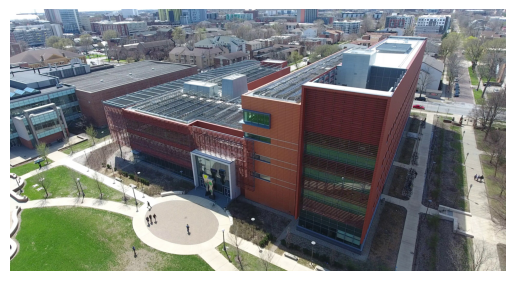

In [30]:
# Click and save the line data for vanishing points. This snippet 
# opens up an interface for selecting points and writes them to 
# data.pickle file. The file is over-written.

num_vpts = 3
all_n, all_lines, all_centers = [], [], []

for i in range(num_vpts):
    print(f'Getting vanishing point {i}')
    
    # Get at least three lines from user input
    n_i, lines_i, centers_i = get_input_lines(im)
    all_n.append(n_i)
    all_lines.append(lines_i)
    all_centers.append(centers_i)

with open('data.pickle', 'wb') as f:
    pickle.dump([all_n, all_lines, all_centers], f)

IndexError: list index out of range

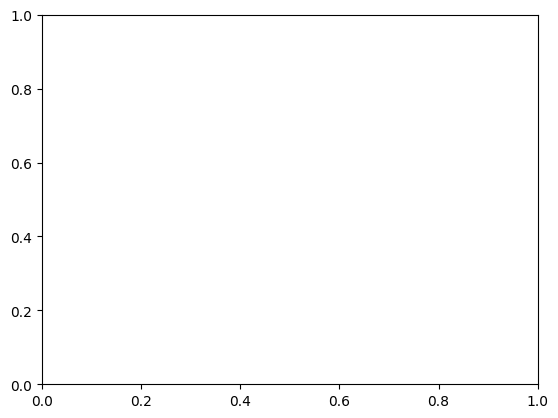

In [ ]:
# Part (1)
# Computing vanishing points for each of the directions
vpts = np.zeros((3, num_vpts))

for i in range(num_vpts):
    fig = plt.figure(); ax = fig.gca()
    
    # <YOUR CODE> Solve for vanishing point
    vpts[:, i] = get_vanishing_point(all_lines[i])
    
    # Plot the lines and the vanishing point
    plot_lines_and_vp(ax, im, all_lines[i], vpts[:, i])
    fig.savefig('Q3_vp{:d}.pdf'.format(i), bbox_inches='tight')

In [ ]:
# Part (2) Computing and plotting the horizon
# <YOUR CODE> Get the ground horizon line
horizon_line = get_horizon_line()

# <YOUR CODE> Plot the ground horizon line
fig = plt.figure(); ax = fig.gca()
plot_horizon_line(...)
fig.savefig('Q3_horizon.pdf', bbox_inches='tight')

In [ ]:
# Part (3) Computing Camera Parameters
# <YOUR CODE> Solve for the camera parameters (f, u, v)
f, u, v, K = get_camera_parameters(...)
print(u, v, f, K)

In [ ]:
# Part (4) Computing Rotation Matrices
# <YOUR CODE> Solve for the rotation matrix
R = get_rotation_matrix(...)
print(R)